The goal of this project is to predict whether a customer with a set of characteristics will churn or not from our company (an Iranian telecom company). To accomplish this goal, the following steps will be taken:
*   Data Importing
*   Data Cleaning
*   Exploratory Data Analysis
*   Data Preprocessing
*   Training and comparing machine learning models performance







# Data Importing

In [3]:
# importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from imblearn.combine import SMOTEENN
from ucimlrepo import fetch_ucirepo

In [4]:
# fetch dataset from UCI Machine Learning Repository
churn_data = fetch_ucirepo(id=563)

# importing data as pandas DataFrames (X containing the features and y containing the labels)
X = churn_data.data.features
y = churn_data.data.targets

In [5]:
# metadata to understand better the dataset
print(churn_data.metadata)

{'uci_id': 563, 'name': 'Iranian Churn', 'repository_url': 'https://archive.ics.uci.edu/dataset/563/iranian+churn+dataset', 'data_url': 'https://archive.ics.uci.edu/static/public/563/data.csv', 'abstract': "This dataset is randomly collected from an Iranian telecom company's database over a period of 12 months.", 'area': 'Business', 'tasks': ['Classification', 'Regression'], 'characteristics': ['Multivariate'], 'num_instances': 3150, 'num_features': 13, 'feature_types': ['Integer'], 'demographics': ['Age'], 'target_col': ['Churn'], 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 2020, 'last_updated': 'Sat Mar 09 2024', 'dataset_doi': '10.24432/C5JW3Z', 'creators': [], 'intro_paper': None, 'additional_info': {'summary': 'This dataset is randomly collected from an Iranian telecom companyâ€™s database over a period of 12 months. A total of 3150 rows of data, each representing a customer, bear information for 13 columns. The attribu

In [6]:
# variable information
print(churn_data.variables)

                       name     role        type demographic description  \
0             Call  Failure  Feature     Integer        None        None   
1                 Complains  Feature      Binary        None        None   
2      Subscription  Length  Feature     Integer        None        None   
3            Charge  Amount  Feature     Integer        None        None   
4            Seconds of Use  Feature     Integer        None        None   
5          Frequency of use  Feature     Integer        None        None   
6          Frequency of SMS  Feature     Integer        None        None   
7   Distinct Called Numbers  Feature     Integer        None        None   
8                 Age Group  Feature     Integer         Age        None   
9               Tariff Plan  Feature     Integer        None        None   
10                   Status  Feature      Binary        None        None   
11                      Age  Feature     Integer         Age        None   
12          

In [7]:
# understanding shape of the dataset
print(X.shape, y.shape)

(3150, 13) (3150, 1)


We verify that our dataset has 3150 observations, each representing a client, and 14 columns, being 13 features and 1 label

# Data Cleaning

From the variable information command used two code blocks above, we identify that there are no missing values to be dealed with. After that, it is important to verify what information the different columns aim to display. We can do that by looking at the dataset documentation available in https://archive.ics.uci.edu/dataset/563/iranian+churn+dataset

By looking at the additional information provided by the dataset's website, two issues come to mind:
*   There is only an 'age group' column in the dataset's description and additional information section, but in the variables table and by inspecting the actual dataframe columns, we identify two age-related columns: **age** and **age group**. Which of them should we use?
*   There are also a **status** and a **churn** columns. We can suppose, reasonably, that a client that is inactive has already churned, so both columns would be measuring the same thing. Again, which column should we use?

For the age-related columns issue, we'll use the **age** column, since it provides greater granularity and is already a numeric variable (in contrast, age group is a categorical ordinal variable). About the status and churn columns, we'll drop the first and maintain the second columns, since the **churn** column is already framed as the label and having a column with this information in the features dataset would not make sense. To finish the data cleaning section, we'll also rename the columns so that they have names that more clearly inform what they are about



In [8]:
# dropping Age Group column
X = X.drop(['Age Group', 'Status'], axis=1)

In [9]:
# renaming columns
X.columns = ['num_call_failures', 'has_complaint', 'sub_length_months',
              'charge_tier', 'total_call_seconds', 'total_num_calls',
              'total_num_sms', 'distinct_call_num', 'type_plan', 'age', 'customer_value']

# Exploratory Data Analysis

In [10]:
# getting summary statistics
X.describe()

,num_call_failures,has_complaint,sub_length_months,charge_tier,total_call_seconds,total_num_calls,total_num_sms,distinct_call_num,type_plan,age,customer_value
count,3150.000000,3150.000000,3150.000000,3150.000000,3150.000000,3150.000000,3150.000000,3150.000000,3150.000000,3150.000000,3150.000000
mean,7.627937,0.076508,32.541905,0.942857,4472.459683,69.460635,73.174921,23.509841,1.077778,30.998413,470.972916
std,7.263886,0.265851,8.573482,1.521072,4197.908687,57.413308,112.237560,17.217337,0.267864,8.831095,517.015433
min,0.000000,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,15.000000,0.000000
25%,1.000000,0.000000,30.000000,0.000000,1391.250000,27.000000,6.000000,10.000000,1.000000,25.000000,113.801250
50%,6.000000,0.000000,35.000000,0.000000,2990.000000,54.000000,21.000000,21.000000,1.000000,30.000000,228.480000
75%,12.000000,0.000000,38.000000,1.000000,6478.250000,95.000000,87.000000,34.000000,1.000000,30.000000,788.388750
max,36.000000,1.000000,47.000000,10.000000,17090.000000,255.000000,522.000000,97.000000,2.000000,55.000000,2165.280000


After calling the describe method, it's clear the necessity of standardizing the data. For example, column 'total_call_seconds' has a mean and median of 4,472 and 2,990, respectively. In contrast, all the other features are, at maximum, in the scale of 100s. This issue will be tackled on the preprocessing step

Another point of attention is in regards of the possible redundancy of our dataset, since, for example, we have three columns of data about customer calls behavior. Are all three of them necessary or is it possible that they are only saying the same thing? Redundancy damages model performance and generalizability, so it's something to pay attention to.

One of the easiest ways to identify redundancy is calculating the correlation between the features in the dataset. A high absolute correlation value between features is a indication of redundancy

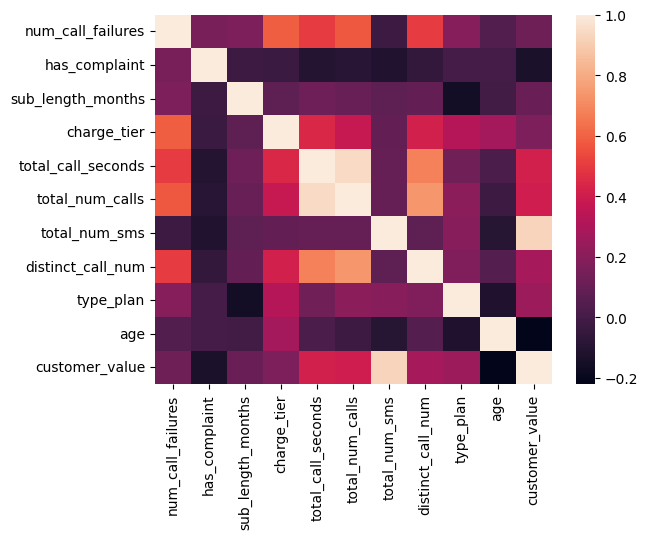

In [11]:
# Plotting a correlation heatamap
sns.heatmap(data=X.corr())
plt.show()

Using the color scale on the right, we identify that there are no high negative correlations, since the scale stops at around -0.4. On the positive part of the scale, the brighter the color, the greater the correlation. We, indeed, see some high correlation between the customer calls behavior data! Let's filter the correlation coefficients that are greater than 0.7

In [12]:
X.corr() > 0.7

,num_call_failures,has_complaint,sub_length_months,charge_tier,total_call_seconds,total_num_calls,total_num_sms,distinct_call_num,type_plan,age,customer_value
num_call_failures,True,False,False,False,False,False,False,False,False,False,False
has_complaint,False,True,False,False,False,False,False,False,False,False,False
sub_length_months,False,False,True,False,False,False,False,False,False,False,False
charge_tier,False,False,False,True,False,False,False,False,False,False,False
total_call_seconds,False,False,False,False,True,True,False,False,False,False,False
total_num_calls,False,False,False,False,True,True,False,True,False,False,False
total_num_sms,False,False,False,False,False,False,True,False,False,False,True
distinct_call_num,False,False,False,False,False,True,False,True,False,False,False
type_plan,False,False,False,False,False,False,False,False,True,False,False
age,False,False,False,False,False,False,False,False,False,True,False


Using a threshold of 0.7, we see that the total number of seconds calling is highly correlated with the total number of calls, which, itself, is highly correlated with the quantity of different numbers called by a client. Because of that, the columns with the total number of seconds calling and with the quantity of different numbers called will be removed to reduce data redundancy

In [13]:
X = X.drop(['total_call_seconds', 'distinct_call_num'], axis=1)

At last, it's interesting to analyze if one plan type has more churn than the other, which **could** indicate that clients of one plan are more likely to churn than clients of the other plan

In [14]:
# Creating dataframe with plan type and churn indicator
churn_by_plan_type = pd.DataFrame({'type_plan': X['type_plan'], 'churn': y['Churn']})

# Grouping by plan type
grouped_churn = churn_by_plan_type.groupby('type_plan').sum()

# Total of clients in each plan type
total_plan_1 = X[X['type_plan'] == 1].shape[0]
total_plan_2 = X[X['type_plan'] == 2].shape[0]

# Creating a column with total number of clients per plan
grouped_churn['total_clients'] = [total_plan_1, total_plan_2]

# Creating column with % churn in each plan
grouped_churn['perc_churn'] = grouped_churn['churn']/grouped_churn['total_clients']

grouped_churn

,churn,total_clients,perc_churn
type_plan,,,
1,489,2905,0.16833
2,6,245,0.02449


From the output above, it's notable that the churns are concentrated on plan type 1. However, this information needs to be used **with caution**, since there are a **lot less** clients from plan type 2 than from plan type 1 and that could influence the churn participation in each plan

We also see that the number of clients who churned is significantly lower than the number of clients that didn't. This is good news for our company but could impact negatively our model's prediction, since it can have a **bias** to predict that more clientes **won't** churn than the reality. We'll train a model both in as-is state and in a artificially balanced dataset to identify which performs better and should be chosen

# Data Preprocessing

In [15]:
# splitting data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X.values, y.values, random_state=123)

In [16]:
# instantiating the scaler
scaler = StandardScaler()

# training the scaler and transforming training data
X_train_scaled = scaler.fit_transform(X_train)

# standardizing test data
X_test_scaled = scaler.transform(X_test)

# Training and comparing machine learning models performance

Since the problem at hand is to predict whether a client, given a set of features, is going to churn or not, we are dealing with a classification problem. We'll compare the performance of two machine learning models: **logistic regression** and **random forests**

Two of the main reasons we'll compare these models:
*   they capture more effectively different types of relations between features (linear and non-linear, respectively)
*   they have training parameters to diminish the effects of class (labels) imbalance

We'll use F1-score as our performance metric and we'll use a 5-fold cross-validation for more robust, comparable and realistc performance assessment

In [17]:
# Instantiating KFold object
kf = KFold(n_splits=5, shuffle=True, random_state=123)

In [18]:
# Logistic Regression
logreg = LogisticRegression(random_state=123, class_weight='balanced')
logreg_score = cross_val_score(logreg, X_train_scaled, y_train.ravel(), cv=kf, scoring='f1')
logreg_score.mean()

0.5887266727966164

In [19]:
# Random Forest
random_forest = RandomForestClassifier(random_state=123, class_weight='balanced')
random_forest_score = cross_val_score(random_forest, X_train_scaled, y_train.ravel(), cv=kf, scoring='f1')
random_forest_score.mean()

0.8049218621278944

Comparing the mean f1-score of both models, it's clear that the random forest model performed better. Therefore, it'll be our choice for the final model

Having chosen the final model architecture, we move on to analysing the impact of class labels imbalance on the model's performance. To accomplish that, we'll create a new, artificially **balanced** dataset, train a random forest model using 5-fold cross-validation and comparing its mean f1-score to the one obtained earlier with the imbalanced dataset

In [20]:
# Creating an instance of a SMOTEENN object
balancer = SMOTEENN(random_state=123)

# Creating a balanced training dataset
X_train_balanced, y_train_balanced = balancer.fit_resample(X_train_scaled, y_train)

# Calculating f1-scores for each fold
balanced_dataset_score = cross_val_score(random_forest, X_train_balanced, y_train_balanced.ravel(), cv=kf, scoring='f1')
balanced_dataset_score.mean()

0.9871289431373385

From the output above, we conclude that, indeed, balancing the training dataset was **significantly** beneficial to our model's performance, going from a 0.80 f1-score in the imbalanced dataset to a 0.99 f1-score in the balanced dataset

## Final Model Development

At last, we'll have our final model at the end of this section! We'll instantiate and train a random forest model using the balanced training dataset, evaluate its performance on the testing dataset and create a prediction function that takes clients' features and generates a prediction of churn or not churn

In [24]:
# Training our random forest model using the balanced training dataset
random_forest.fit(X_train_balanced, y_train_balanced)

# Generating model's predictions for test data
test_predictions = random_forest.predict(X_test_scaled)

# Calculating f1_score and printing it
score = f1_score(y_test, test_predictions)
score

0.8013468013468014

In [25]:
# Creating the function that takes predicts if a customer will churn or not
def predicting_churn(input_dict):
    """
    This function takes a dictionary as input (features: values) and generates a prediction of whether the customer will churn or not.
    A 0 indicates no churn, whereas a 1 indicates churn

    Notice that the dictionary must be in the following format to be accepted by this function:
    {'num_call_failures': [val_1], 'has_complaints': [val_2], 'sub_length_months': [val_3],
    'charge_tier': [val_4], 'total_num_calls': [val_5], 'total_num_sms': [val_6],
    'type_plan': [val_7], 'age': [val_8], 'customer_value': [val_9]}

    val_2 must be either 0 or 1, val_4 must be between 0 and 9 and val_7 must be either 1 or 2
    """
    if list(input_dict.keys()) != list(X.columns):
        return 'The input data was sent incorrectly. Send the values in correct order'
    else:
        input_df = pd.DataFrame(input_dict)
        scaled_input_df = scaler.transform(input_df.values)
        prediction = random_forest.predict(scaled_input_df)
        return prediction

In [27]:
# Making a prediction
predicting_churn({'num_call_failures': [5], 'has_complaint': [0], 'sub_length_months': [15],
                  'charge_tier': [7], 'total_num_calls': [50], 'total_num_sms': [20],
                  'type_plan': [1], 'age': [45], 'customer_value': [50000]})

'not churn'